> ### Note on Labs and Assignments:
>
> 🔧 Look for the **wrench emoji** 🔧 — it highlights where you're expected to take action!
>
> These sections are graded and are not optional.
>

# IS 4487 Lab 9: Clustering

In this lab, we return to the **SF Rent** dataset that we used in **Lab 4: Data Understanding** and **Lab 5: Exploratory Data Analysis (EDA)**.

This time, we’ll explore how to segment the counties using both:
- **Manual clustering** based on business rules
- **Automatic clustering** using KMeans clustering

Segmentation helps identify meaningful groups within data, such as counties with high rent burden or low affordability. This is valuable for making targeted decisions in housing policy, urban planning, and social support.


## Outline

- Load and inspect the SF Rents dataset  
- Engineer and prepare features  
- Create manual segments using binning  
- Perform KMeans clustering for automatic segments  
- Visualize and compare results  

<a href="https://colab.research.google.com/github/vandanara/UofUtah_IS4487/blob/main/Labs/lab_09_clustering.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Dataset Overview

**Dataset:** `rent.csv`  
Source: [TidyTuesday – 2022-07-05](https://github.com/rfordatascience/tidytuesday/blob/main/data/2022/2022-07-05/rent.csv)

| Variable       | Type       | Description |
|----------------|------------|-------------|
| `post_id`      | Categorical| Unique listing ID |
| `date`         | Numeric    | Listing date (numeric format) |
| `year`         | Integer    | Year of listing |
| `nhood`        | Categorical| Neighborhood |
| `city`         | Categorical| City |
| `county`       | Categorical| County |
| `price`        | Numeric    | Listing price (USD) |
| `beds`         | Numeric    | Number of bedrooms |
| `baths`        | Numeric    | Number of bathrooms |
| `sqft`         | Numeric    | Square footage |
| `room_in_apt`  | Binary     | 1 = room in apartment |
| `address`      | Categorical| Street address |
| `lat`          | Numeric    | Latitude |
| `lon`          | Numeric    | Longitude |
| `title`        | Text       | Listing title |
| `descr`        | Text       | Listing description |
| `details`      | Text       | Additional details |


## Part 1: Importing the Data + Prepare for Segmentation

### Instructions:
- Import the `pandas` library.
- Import data from the rent.csv into a dataframe from the tidytuesday link.
- Use `.info()` and `.head()` to inspect the structure and preview the data.e structure and preview the data.
- Remove duplicates
- Handle missing values
- Remove outliers (for price, beds, baths, sqft)
- Fix data types
- Optionally impute or filter variables

In [16]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2022/2022-07-05/rent.csv'
df = pd.read_csv(url)

# Get a quick overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200796 entries, 0 to 200795
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   post_id      200796 non-null  object 
 1   date         200796 non-null  int64  
 2   year         200796 non-null  int64  
 3   nhood        200796 non-null  object 
 4   city         200796 non-null  object 
 5   county       199402 non-null  object 
 6   price        200796 non-null  int64  
 7   beds         194188 non-null  float64
 8   baths        42675 non-null   float64
 9   sqft         64679 non-null   float64
 10  room_in_apt  200796 non-null  int64  
 11  address      3908 non-null    object 
 12  lat          7651 non-null    float64
 13  lon          4312 non-null    float64
 14  title        198279 non-null  object 
 15  descr        3254 non-null    object 
 16  details      8016 non-null    object 
dtypes: float64(5), int64(4), object(8)
memory usage: 26.0+ MB


In [17]:
df.head()

,post_id,date,year,nhood,city,county,price,beds,baths,sqft,room_in_apt,address,lat,lon,title,descr,details
0,pre2013_134138,20050111,2005,alameda,alameda,alameda,1250,2.0,2.0,NaN,0,NaN,NaN,NaN,$1250 / 2br - 2BR/2BA 1145 ALAMEDA DE LAS PU...,NaN,NaN
1,pre2013_135669,20050126,2005,alameda,alameda,alameda,1295,2.0,NaN,NaN,0,NaN,NaN,NaN,$1295 / 2br - Walk the Beach! 1 FREE MONTH + $...,NaN,NaN
2,pre2013_127127,20041017,2004,alameda,alameda,alameda,1100,2.0,NaN,NaN,0,NaN,NaN,NaN,$1100 / 2br - cottage,NaN,NaN
3,pre2013_68671,20120601,2012,alameda,alameda,alameda,1425,1.0,NaN,735.0,0,NaN,NaN,NaN,$1425 / 1br - 735ft² - BEST LOCATION SOUTHSHOR...,NaN,NaN
4,pre2013_127580,20041021,2004,alameda,alameda,alameda,890,1.0,NaN,NaN,0,NaN,NaN,NaN,"$890 / 1br - Classy ""Painted Lady"" VICTORIAN -...",NaN,NaN


In [18]:
# STEP 1: Drop duplicates
df = df.drop_duplicates(subset='post_id')

# STEP 2: Drop rows with nulls in essential columns
essential = ['price', 'beds', 'baths', 'sqft', 'lat', 'lon']
df = df.dropna(subset=essential)

# STEP 3: Remove outliers (common-sense filtering)
df = df[df['price'].between(500, 20000)]
df = df[df['beds'].between(0, 10)]
df = df[df['baths'].between(0.5, 10)]
df = df[df['sqft'].between(100, 5000)]

# STEP 4: Convert data types if needed
df['beds'] = df['beds'].astype(int)
df['baths'] = df['baths'].astype(float)  # decimal values allowed
df['sqft'] = df['sqft'].astype(int)
df['price'] = df['price'].astype(int)

# STEP 5: Reset index
df = df.reset_index(drop=True)

# Preview cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_id      1984 non-null   object 
 1   date         1984 non-null   int64  
 2   year         1984 non-null   int64  
 3   nhood        1984 non-null   object 
 4   city         1984 non-null   object 
 5   county       1979 non-null   object 
 6   price        1984 non-null   int64  
 7   beds         1984 non-null   int64  
 8   baths        1984 non-null   float64
 9   sqft         1984 non-null   int64  
 10  room_in_apt  1984 non-null   int64  
 11  address      1768 non-null   object 
 12  lat          1984 non-null   float64
 13  lon          1984 non-null   float64
 14  title        1855 non-null   object 
 15  descr        1847 non-null   object 
 16  details      1874 non-null   object 
dtypes: float64(3), int64(6), object(8)
memory usage: 263.6+ KB


In [19]:
df.head()

,post_id,date,year,nhood,city,county,price,beds,baths,sqft,room_in_apt,address,lat,lon,title,descr,details
0,4817227421,20141223,2014,alameda,alameda,alameda,1939,2,1.0,864,0,NaN,37.770600,-122.264800,"LIVE MORE, DRIVE LESS! JUST ACROSS THE BAY FRO...","Summer House Apartments 1826 Poggi St, Alameda...","2BR / 1Ba 864ft2 apartment date=""2014-12-23"" ..."
1,4710888130,20141012,2014,alameda,alameda,alameda,2250,2,1.0,1080,0,659,37.772835,-122.248585,2br Victortian Duplex Garden Apt.,"This 1903 ""Workingman's Victorian"" on a quiet ...","2BR / 1Ba 1080ft2 apartment date=""2014-11-02""..."
2,5961989126,20170126,2017,alameda,alameda,alameda,3995,3,2.0,1787,0,NaN,37.759231,-122.247190,3 BR/2 BA Queene Anne on Park St.,This charming 1787 sq ft meticulously maintain...,"3BR / 2Ba1787ft2 data-date=""2017-02-01"" data-t..."
3,4935175730,20150316,2015,alameda,alameda,alameda,2536,2,2.0,1225,0,NaN,37.753609,-122.249081,Spacious 2BR/2BA in a Great Community!,Tower Apartments CALL US: show contact infox3...,"2BR / 2Ba 1225ft2 apartment date=""2015-04-19""..."
4,4988581576,20150421,2015,alameda,alameda,alameda,2650,2,1.0,950,0,497,37.758922,-122.263314,"Upgraded 2B w/ Pool View, Short Walk to School...",Enjoy and experience the relaxing atmosphere o...,"2BR / 1Ba 950ft2 apartment date=""2015-04-20"" ..."


## Part 2: Engineer and Prepare Features

We’ll select features for clustering:
- Property: `price`, `beds`, `baths`, `sqft`
- Geographic: `lat`, `lon`

We’ll standardize features to ensure fair weighting in distance-based clustering.

### Why This Matters:
Standardization avoids giving larger-scale variables (like `price`) more influence.

### Things to think about:
- Should all variables be scaled?
- Do geographic coordinates need standardization?


In [20]:
from sklearn.preprocessing import StandardScaler

# Select and scale features
features = ['price', 'beds', 'baths', 'sqft', 'lat', 'lon']
segment_df = df[features].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(segment_df)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df.head()


,price,beds,baths,sqft,lat,lon
0,-0.657774,-0.036416,-0.772941,-0.536093,0.429432,-0.403353
1,-0.473068,-0.036416,-0.772941,-0.165325,0.436382,-0.339893
2,0.563306,0.855552,0.682697,1.048255,0.394079,-0.334434
3,-0.303210,-0.036416,0.682697,0.083571,0.376597,-0.341835
4,-0.235504,-0.036416,-0.772941,-0.388473,0.393118,-0.397537


### 🔧 Try It Yourself – Part 2

1. Why should lat/lon (latitude and longitude) be scaled before clustering? What would happen if they weren’t? (There’s no coding here, just write your response below.)

🔧 Add comment here: They should be scaled before clustering so their values are on the same sclae as the other features in the dataset. If they are not scaled, geographic distance would dominate the clustering process and mess up our grouping.

## Part 3: Create Manual Segments Using Binning

Let’s group listings by price into:
- **Low**: < $2,000
- **Mid**: $2,000–$4,000
- **High**: > $4,000

### Why This Matters:
Manual bins based on thresholds offer simple segmentation — useful when business rules exist.

### Things to think about:
- Are fixed cutoffs better than percentiles?
- Should you also bin square footage?


In [21]:
# Create price segments
df['price_segment'] = pd.cut(
    df['price'],
    bins=[0, 2000, 4000, float('inf')],
    labels=['Low', 'Mid', 'High']
)

df['price_segment'].value_counts()


,count
price_segment,
Mid,1195
Low,493
High,296


### 🔧 Try It Yourself – Part 3

1. Create a column called `sqft_segment` using bins:  
  - Small: `< 800`, Medium: `800–1400`, Large: `>1400`  
2. Count how many listings fall into each `sqft_segment` using `.value_counts()`  
3. Use `.head()` to preview both `price_segment` and `sqft_segment`

In [22]:
# 🔧 # Create sqft_segment column based on bins
df['sqft_segment'] = pd.cut(
    df['sqft'],
    bins=[0, 800, 1400, float('inf')],
    labels=['Small', 'Medium', 'Large']
)

# Count how many listings fall into each segment
print(df['sqft_segment'].value_counts())

# Preview both price_segment and sqft_segment
print(df[['price_segment', 'sqft_segment']].head())


sqft_segment
Medium    944
Small     536
Large     504
Name: count, dtype: int64
  price_segment sqft_segment
0           Low       Medium
1           Mid       Medium
2           Mid        Large
3           Mid       Medium
4           Mid       Medium


## Part 4: Perform KMeans Clustering

We’ll create two sets of clusters:
1. **Feature-based** (price, beds, baths, sqft)
2. **Geographic-based** (lat, lon)

### Why This Matters:
Unsupervised clustering finds hidden patterns — useful for market segmentation, targeting, etc.

### Things to think about:
- How many clusters should you use?
- How do results differ between property and location clusters?


In [23]:
from sklearn.cluster import KMeans

# Select only the standardized property features
X_feat = scaled_df[['price', 'beds', 'baths', 'sqft']]

# Apply KMeans clustering with 4 clusters
kmeans_feat = KMeans(n_clusters=4, random_state=1)
scaled_df['feature_cluster'] = kmeans_feat.fit_predict(X_feat)

# Show number of listings in each cluster
scaled_df['feature_cluster'].value_counts()


,count
feature_cluster,
0,962
3,652
1,318
2,52


In [24]:
# Select only standardized geographic coordinates
X_geo = scaled_df[['lat', 'lon']]

# Apply KMeans clustering with 5 clusters
kmeans_geo = KMeans(n_clusters=5, random_state=1)
scaled_df['geo_cluster'] = kmeans_geo.fit_predict(X_geo)

# Show number of listings in each geographic cluster
scaled_df['geo_cluster'].value_counts()

,count
geo_cluster,
1,692
2,610
0,335
4,230
3,117


### 🔧 Try It Yourself – Part 4

1. Run KMeans again using `k=3` (3 clusters instead of 4). Then compare the value counts of the old KMeans with your new KMeans.
2. Plot a histogram of `price` grouped by `feature_cluster`  

Cluster size comparison:
   k=4   k=3
0  962  1032
1  318   807
2   52   145
3  652     0


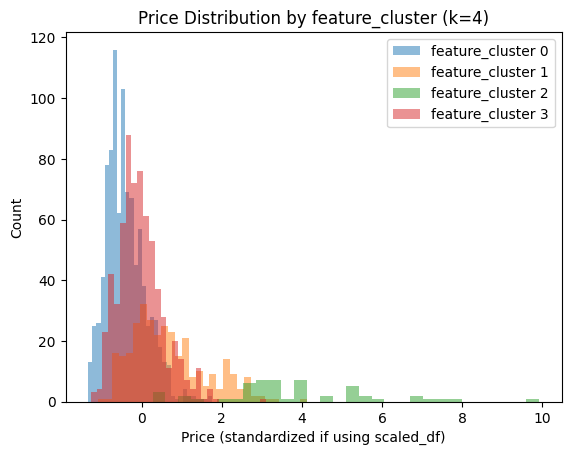

In [25]:
# 🔧 from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Keep your existing 4-cluster labels
scaled_df['feature_cluster_k4'] = scaled_df['feature_cluster']

# 2) Refit KMeans with k=3 on the same (standardized) feature set
X_feat = scaled_df[['price', 'beds', 'baths', 'sqft']]
kmeans_feat_k3 = KMeans(n_clusters=3, random_state=1)
scaled_df['feature_cluster_k3'] = kmeans_feat_k3.fit_predict(X_feat)

# 3) Compare value counts (k=4 vs k=3)
k4_counts = scaled_df['feature_cluster_k4'].value_counts().sort_index()
k3_counts = scaled_df['feature_cluster_k3'].value_counts().sort_index()

comparison = pd.DataFrame({
    'k=4': k4_counts,
    'k=3': k3_counts
}).fillna(0).astype(int)

print("Cluster size comparison:")
print(comparison)

# 4) Plot histogram of price grouped by feature_cluster
# If you still have the original (unscaled) df with dollar prices, use df['price'].
# Otherwise this will plot standardized price from scaled_df['price'].
price_source = 'price' if 'price' in scaled_df.columns else None  # standardized price column
# (If you kept an original df, swap to: price_series = df['price'])

plt.figure()
for c in sorted(scaled_df['feature_cluster_k4'].unique()):
    subset = scaled_df[scaled_df['feature_cluster_k4'] == c]
    plt.hist(subset['price'], bins=30, alpha=0.5, label=f'feature_cluster {c}', density=False)

plt.title('Price Distribution by feature_cluster (k=4)')
plt.xlabel('Price (standardized if using scaled_df)')
plt.ylabel('Count')
plt.legend()
plt.show()


## Part 5: Visualize and Compare Results

We’ll now visualize:
- Clusters on a map (lat/lon)
- Clusters in price vs sqft space

### Why This Matters:
Visual validation helps determine if clusters are interpretable and useful.

### Things to think about:
- Are location clusters geographically meaningful?
- Do property clusters separate by price or size?

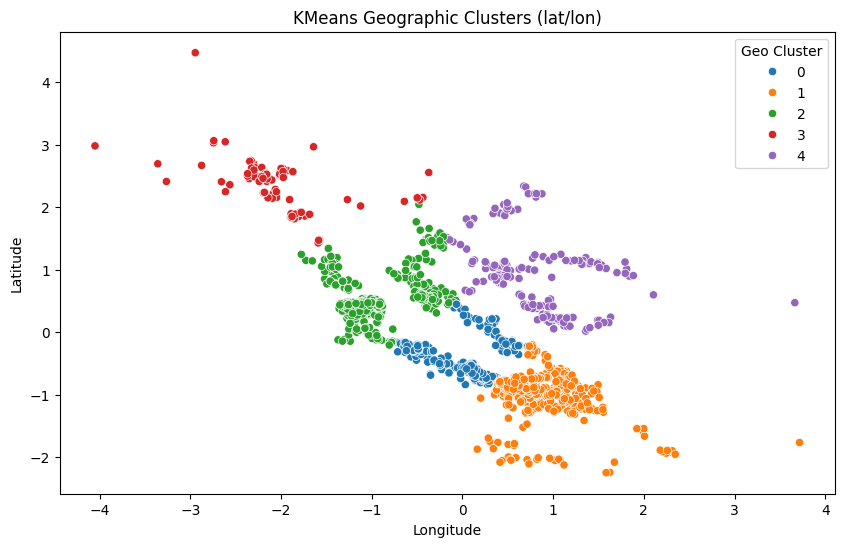

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot latitude vs longitude colored by geographic cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=scaled_df,
                x='lon',
                y='lat',
                hue='geo_cluster',
                palette='tab10')

plt.title("KMeans Geographic Clusters (lat/lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Geo Cluster')
plt.show()

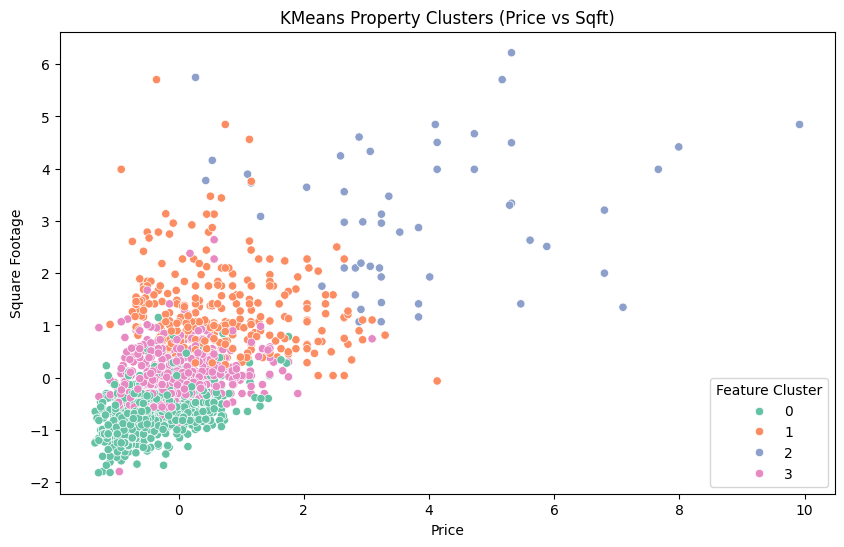

In [27]:
# Plot price vs square footage colored by feature cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=scaled_df,
                x='price',
                y='sqft',
                hue='feature_cluster',
                palette='Set2')

plt.title("KMeans Property Clusters (Price vs Sqft)")
plt.xlabel("Price")
plt.ylabel("Square Footage")
plt.legend(title='Feature Cluster')
plt.show()

### 🔧 Try It Yourself – Part 5

In past assignments you’ve created scatterplots where the size of each point depended on how large each value was. And you’ve created scatterplots where the color of each point was assigned many or few colors.

1. Add `beds` as the **point size** in your scatterplot of `price` vs `sqft`  
2. Add `baths` as the **point style** in your `sns.scatterplot()`  
3. Group by `feature_cluster` and calculate:
  - Average `price`
  - Average `sqft`
  - Average `beds`  


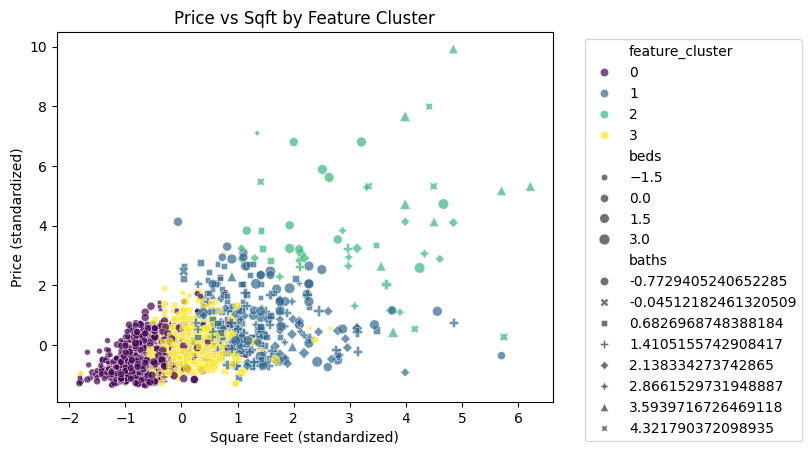

Average values by feature_cluster:
   feature_cluster  avg_price  avg_sqft  avg_beds
0                0  -0.406484 -0.644175 -0.698438
1                1   0.670697  1.272385  1.267877
2                2   3.831001  3.128546  1.867593
3                3  -0.032908  0.080359  0.263187


In [28]:
# 🔧 import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Scatterplot of price vs sqft
# - Point size = beds
# - Point style = baths
# - Color = feature_cluster
sns.scatterplot(
    data=scaled_df,
    x='sqft',
    y='price',
    hue='feature_cluster',
    size='beds',
    style='baths',
    palette='viridis',
    alpha=0.7
)
plt.title('Price vs Sqft by Feature Cluster')
plt.xlabel('Square Feet (standardized)')
plt.ylabel('Price (standardized)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 2) Group by feature_cluster and compute averages
avg_stats = (
    scaled_df.groupby('feature_cluster')[['price', 'sqft', 'beds']]
    .mean()
    .rename(columns={
        'price': 'avg_price',
        'sqft': 'avg_sqft',
        'beds': 'avg_beds'
    })
    .reset_index()
)

print("Average values by feature_cluster:")
print(avg_stats)


## Part 6: Evaluate the Fit for your Clusters

We’ll now use three methods to evaluate the fit:
- WCSS
- Silhouette score
- Davies-bouldin index

### Why This Matters:
Clusters are difficult to visualize when they are based on more than 3 variables.  A statistical score will evaluate the fit across all of the variables.

### Things to think about:
- Lower WCSS = tighter, better-defined clusters
- Silhouette score ranges from -1 to 1.  Higher values = better clustering
- Lower Davies-Boulding Index = better clustering

### 🔧 Try It Yourself – Part 6

Calculate the three scores for your **feature-based** cluster model by using the following methods:
- WCSS
- Silhouette score
- Davies-bouldin index

In [29]:
# 🔧 from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import silhouette_score, davies_bouldin_score

# X_feat is your standardized feature set
X_feat = scaled_df[['price', 'beds', 'baths', 'sqft']]

# Reuse the fitted model (kmeans_feat) or fit it again
kmeans_feat = KMeans(n_clusters=4, random_state=1)
kmeans_feat.fit(X_feat)

# 1) WCSS (Within-Cluster Sum of Squares)
wcss = kmeans_feat.inertia_

# 2) Silhouette Score
silhouette = silhouette_score(X_feat, kmeans_feat.labels_)

# 3) Davies–Bouldin Index
db_index = davies_bouldin_score(X_feat, kmeans_feat.labels_)

print("Cluster Evaluation Metrics (Feature-based Model)")
print(f"WCSS: {wcss:.2f}")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies–Bouldin Index: {db_index:.3f}")


Cluster Evaluation Metrics (Feature-based Model)
WCSS: 3092.40
Silhouette Score: 0.335
Davies–Bouldin Index: 1.280


## 🔧 Part 7: Reflection (100 words or less per question)

1. Which method—manual binning or KMeans clustering—gave you more useful insights?

2. How might missing data or outliers affect your segmentation results?


🔧 Add comment here:

- KMeans gave better insights because it was able to group listings based on multiple features, which can uncover patterns that are hard to discern with the naked eye. Manual binning may be easier to look at, KMeans is much more data driven and is able to find relationships between variables.

- Missing data can distort clustering by reducing the number of observations in the dataset that are usaable or bias. Both outliers and missing data are going ot be huge problems in clustering becuase they will pull the clusters in directions they should not go and distort our findings.

## Export Your Notebook to Submit in Canvas
- Use the instructions from Lab 1

In [31]:
!jupyter nbconvert --to html "lab_09_WoodMason.ipynb"

[NbConvertApp] Converting notebook lab_09_WoodMason.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 807524 bytes to lab_09_WoodMason.html
